In [3]:
import torch
import json
import numpy as np
import pandas as pd

from torch import nn
from sklearn.metrics import f1_score
from utils import get_loaders
from classifier_utils import HateSpeechClassifier, forward_back_prop, \
                             train_classifier, batch_test, plot_confusion_matrices

tweets = np.load("data/tweets.npy")
labels = np.load("data/hate_original.npy")

with open('vocab_to_int.json', 'r') as fp:
    vocab_to_int = json.load(fp)

with open('int_to_vocab.json', 'r') as fp:
    int_to_vocab = json.load(fp)
    
train_on_gpu = torch.cuda.is_available()
print("Using GPU." if train_on_gpu else "Using CPU.")

Using GPU.


### Creating the Training, Validation, and Test Sets

In [4]:
batch_size = 80
train_loader, valid_loader, test_loader = get_loaders(tweets, labels, 
                                                      train_frac=0.8, remain_split_frac=0.5, 
                                                      batch_size=batch_size)

			Feature Shapes:
Train set: 		(19826, 100) 
Validation set: 	(2478, 100) 
Test set: 		(2479, 100)


In [5]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([80, 100])
Sample input: 
 tensor([[    0,     0,     0,  ..., 11482, 12514, 12074],
        [    0,     0,     0,  ..., 16982,  8043, 18520],
        [    0,     0,     0,  ...,  5932,  5932,  5932],
        ...,
        [    0,     0,     0,  ..., 13793, 13942, 12074],
        [    0,     0,     0,  ..., 18159, 20048,  3029],
        [    0,     0,     0,  ...,  2025, 18805,  2025]], dtype=torch.int32)

Sample label size:  torch.Size([80])
Sample label: 
 tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 0, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 0, 2, 2, 1,
        1, 2, 1, 1, 1, 1, 2, 1])


# 1. Replication: Hemker (2018)

### Hyperparameters

In [4]:
sequence_length = tweets.shape[1]  # number of words in a sequence
num_epochs = 10
learning_rate = 0.01
momentum = 0.7
vocab_size = len(vocab_to_int)
output_size = pd.Series(labels).nunique()
embedding_dim = 300
hidden_dim = 256
n_layers = 1
show_every_n_batches = 50
cnn_params = (256, 25, 9, 3) # out_channels, kernel_size, stride, padding
pool_params = (4, 2, 0)

### Model Instantiation

In [5]:
model = HateSpeechClassifier(vocab_size, output_size, embedding_dim, 
                             cnn_params, pool_params, hidden_dim, n_layers,
                             p_dropout = 0,
                             embedding_path="glove/glove.42B.300d.txt", 
                             vocab_to_int=vocab_to_int, train_on_gpu=train_on_gpu)

if train_on_gpu:
    model.cuda()

Setting pretrained embedding weights...
3362 words in the vocabulary have no pre-trained embedding.


### Train network

In [6]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [7]:
model = train_classifier(model, batch_size, optimizer, criterion, num_epochs, train_loader, valid_loader,
                         show_every_n_batches=show_every_n_batches)

Training for 10 epoch(s)...
Epoch: 1/10. 	Batch: 50/248.	 Avg. Training Loss: 1.80878200173378
Epoch: 1/10. 	Batch: 100/248.	 Avg. Training Loss: 1.7172680473327637
Epoch: 1/10. 	Batch: 150/248.	 Avg. Training Loss: 1.4060333935419718
Epoch: 1/10. 	Batch: 200/248.	 Avg. Training Loss: 1.2487317737936974
Epoch: 1 	Training Loss: 1.163507 	Validation Loss: 1.431189 	 Accuracy: 5.500000

Epoch: 2/10. 	Batch: 50/248.	 Avg. Training Loss: 0.9025145483016968
Epoch: 2/10. 	Batch: 100/248.	 Avg. Training Loss: 0.8209758350253105
Epoch: 2/10. 	Batch: 150/248.	 Avg. Training Loss: 0.8519191827376683
Epoch: 2/10. 	Batch: 200/248.	 Avg. Training Loss: 0.846410525739193
Epoch: 2 	Training Loss: 0.828247 	Validation Loss: 1.044822 	 Accuracy: 22.583333

Epoch: 3/10. 	Batch: 50/248.	 Avg. Training Loss: 0.7955399417877197
Epoch: 3/10. 	Batch: 100/248.	 Avg. Training Loss: 0.7944435286521911
Epoch: 3/10. 	Batch: 150/248.	 Avg. Training Loss: 0.7786097143093745
Epoch: 3/10. 	Batch: 200/248.	 Avg. Train

### Test network

In [8]:
test_loss, test_acc, y_true, y_pred = batch_test(model, batch_size, test_loader, criterion, prnt=True)

Test loss: 1.548
Test accuracy: 16.8%


In [9]:
print("F1 Scores : {:.3f}, {:.3f}, {:.3f}".format(*f1_score(y_pred, y_true, average=None)))

F1 Scores : 0.000, 0.000, 0.295


C:\ProgramData\Anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Confusion matrix, without normalization
Normalized confusion matrix


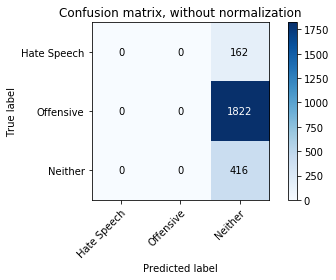

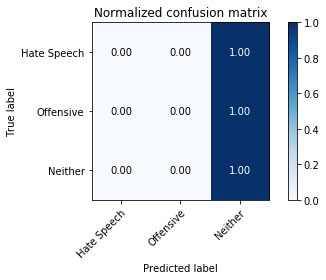

In [10]:
plot_confusion_matrices(y_true, y_pred)

In [11]:
del model
torch.cuda.empty_cache()

# 2. Learning Rate: 0.01 → 0.001

### Hyperparameters

In [6]:
sequence_length = tweets.shape[1]  # number of words in a sequence
num_epochs = 10
learning_rate = 0.001
momentum = 0.7
vocab_size = len(vocab_to_int)
output_size = pd.Series(labels).nunique()
embedding_dim = 300
hidden_dim = 256
n_layers = 1
show_every_n_batches = 50
cnn_params = (256, 25, 9, 3) # out_channels, kernel_size, stride, padding
pool_params = (4, 2, 0)

### Model Instantiation

In [7]:
model = HateSpeechClassifier(vocab_size, output_size, embedding_dim, 
                             cnn_params, pool_params, hidden_dim, n_layers,
                             p_dropout = 0,
                             embedding_path="glove/glove.42B.300d.txt", 
                             vocab_to_int=vocab_to_int, train_on_gpu=train_on_gpu)

if train_on_gpu:
    model.cuda()

Setting pretrained embedding weights...
3362 words in the vocabulary have no pre-trained embedding.


### Train network

In [8]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [9]:
model = train_classifier(model, batch_size, optimizer, criterion, num_epochs, train_loader, valid_loader,
                         show_every_n_batches=show_every_n_batches, save_path="temp_model.pth")

Training for 10 epoch(s)...
Epoch: 1/10. 	Batch: 50/248.	 Avg. Training Loss: 0.5549421525001526
Epoch: 1/10. 	Batch: 100/248.	 Avg. Training Loss: 0.4628845199942589
Epoch: 1/10. 	Batch: 150/248.	 Avg. Training Loss: 0.4183327858646711
Epoch: 1/10. 	Batch: 200/248.	 Avg. Training Loss: 0.39938925080001353
Epoch: 1 	Training Loss: 0.380695 	Validation Loss: 0.314797 	 Accuracy: 89.500000

Validation loss decreased (inf --> 0.314797).  Saving model ...

Epoch: 2/10. 	Batch: 50/248.	 Avg. Training Loss: 0.24989224642515181
Epoch: 2/10. 	Batch: 100/248.	 Avg. Training Loss: 0.23520538579672576
Epoch: 2/10. 	Batch: 150/248.	 Avg. Training Loss: 0.24161797610421976
Epoch: 2/10. 	Batch: 200/248.	 Avg. Training Loss: 0.24050192831084133
Epoch: 2 	Training Loss: 0.242670 	Validation Loss: 0.297789 	 Accuracy: 89.083333

Validation loss decreased (0.314797 --> 0.297789).  Saving model ...

Epoch: 3/10. 	Batch: 50/248.	 Avg. Training Loss: 0.17147704899311067
Epoch: 3/10. 	Batch: 100/248.	 Avg. 

In [10]:
# Load saved model
model.load_state_dict(torch.load("temp_model.pth"))

<All keys matched successfully>

### Test network

In [11]:
test_loss, test_acc, y_true, y_pred = batch_test(model, batch_size, test_loader, criterion, prnt=True)

Test loss: 0.296
Test accuracy: 86.0%


Confusion matrix, without normalization
Normalized confusion matrix


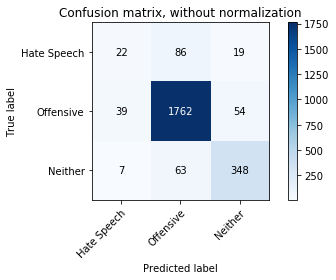

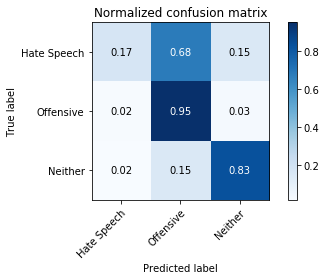

In [12]:
plot_confusion_matrices(y_true, y_pred)

In [13]:
print("F1 Scores : {:.3f}, {:.3f}, {:.3f}".format(*f1_score(y_pred, y_true, average=None)))

F1 Scores : 0.226, 0.936, 0.830


In [14]:
del model
torch.cuda.empty_cache()